## PREPROCESSING

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
train=pd.read_csv("./data/train2.csv").drop(["Unnamed: 0"],axis=1)
train["SalePrices"]=train["SalePrice"]
train=train.drop(["SalePrice"],axis=1)
test=pd.read_csv("./data/test2.csv").drop(["Unnamed: 0"],axis=1)
train.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_None,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,...,Total_Home_Quality,TotalSF,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,SalePrices
0,0,0,1,0,1,0,0,0,1,0,...,12,2566,3.5,4.127134,0.0,1,1,1,0,12.247699
1,0,0,1,0,1,0,0,0,1,0,...,14,2524,2.5,5.700444,0.0,0,1,1,1,12.109016
2,0,0,1,0,1,0,0,0,0,0,...,12,2706,3.5,3.761200,0.0,1,1,1,1,12.317171
3,0,0,1,0,1,0,0,0,0,0,...,12,2473,2.0,5.730100,0.0,1,1,1,1,11.849405
4,0,0,1,0,1,0,0,0,0,0,...,13,3343,3.5,5.624018,0.0,1,1,1,1,12.429220


## MACHINE LEARNING : RIDGE

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge, Lasso, SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor


y=train.iloc[:,-1]
X=train.iloc[:,:-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [3]:
np.random.seed(5)
Model = Ridge(15)
Model = Model.fit(X_train, y_train)

ypred_train=Model.predict(X_train).reshape(-1,1)
ypred_test=Model.predict(X_test).reshape(-1,1)
r2_score_train=r2_score(y_train.values.reshape(-1,1), ypred_train)
r2_score_test=r2_score(y_test.values.reshape(-1,1), ypred_test)

print("R2_score_train ",round(r2_score_train,3))
print("R2_score_test ",round(r2_score_test,3))
print("MAE_train ",round(mean_absolute_error(np.expm1(y_train.values.reshape(-1,1)), np.expm1(ypred_train))))
print("MAE_test ",round(mean_absolute_error(np.expm1(y_test.values.reshape(-1,1)), np.expm1(ypred_test))),"\n")

R2_score_train  0.938
R2_score_test  0.92
MAE_train  11885.0
MAE_test  13958.0 



Le modèle de Ridge regression permet de viser une Mean Absolute Error de +/- 14K€ sur l'échantillon de test ce qui est confortable. Plottons les learning curve pour analyser la pertinence du modèle.

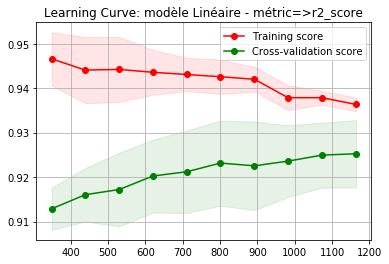

In [4]:
#LEARNING CURVES ANALYSIS
from sklearn.model_selection import learning_curve, ShuffleSplit
cv= ShuffleSplit(n_splits=3, test_size=0.2, random_state=4)
Model = Ridge(15)
train_sizes, train_scores, test_scores=learning_curve(Model, X, y,cv=cv, train_sizes=np.linspace(.3, 1.0, 10), scoring="r2")

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()
plt.title("Learning Curve: modèle Linéaire - métric=>r2_score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")


On observe que le modèle est plutôt bien dimensionné en terme de complexité. L'évolution des performances est relativement statique à partir de 1100 observations ce qui révèle un début d'underfitting. D'après ces résultats, l'implémentation d'un réseau de neurone est suceptible, d'aider à la reconnaissance de patterns plus complexes au sein des données.

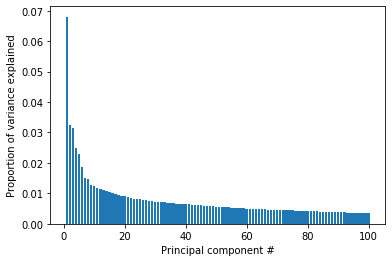

In [5]:
#PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
X=train.iloc[:,:-1]
y=train.iloc[:,-1]

X_normalized = StandardScaler().fit_transform(X) 
pca=PCA(100).fit(X_normalized)

import matplotlib.pyplot as plt
plt.bar(range(1, pca.n_components_ + 1),  pca.explained_variance_ratio_)
plt.xlabel('Principal component #')
plt.ylabel('Proportion of variance explained')
plt.show()


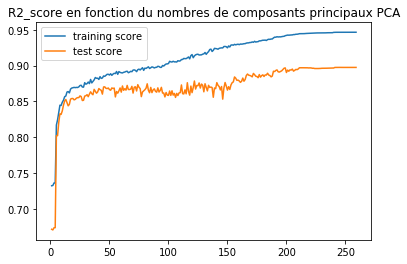

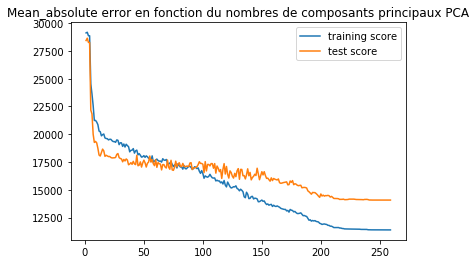

In [6]:
#TRAINING AVEC PCA
rtrain=[]
rtest=[]
mtrain=[]
mtest=[]
for i in range(1,260):
    X=train.iloc[:,:-1]
    y=train.iloc[:,-1]

    X_normalized = StandardScaler().fit_transform(X) 
    
    X_pca=PCA(i).fit_transform(X_normalized)
    
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=777)

    np.random.seed(5)
    Model = Ridge(alpha=100,max_iter=10000)
    Model = Model.fit(X_train, y_train)

    rtrain.append(Model.score(X_train,y_train))
    rtest.append(Model.score(X_test,y_test))
    
    ypred_train=Model.predict(X_train).reshape(-1,1)
    ypred_test=Model.predict(X_test).reshape(-1,1)
    mtrain.append(mean_absolute_error(np.expm1(y_train.values.reshape(-1,1)), np.expm1(ypred_train)))
    mtest.append(mean_absolute_error(np.expm1(y_test.values.reshape(-1,1)), np.expm1(ypred_test)))
    
plt.figure()
plt.plot(list(range(1,260)),rtrain, label="training score")
plt.plot(list(range(1,260)),rtest, label="test score")
plt.title("R2_score en fonction du nombres de composants principaux PCA")
plt.legend()

plt.figure()
plt.plot(list(range(1,260)),mtrain, label="training score")
plt.plot(list(range(1,260)),mtest, label="test score")
plt.title("Mean_absolute error en fonction du nombres de composants principaux PCA")
plt.legend()

En conclusion, réduire le nombre de dimensions à 100 au lieu de 263 permet de viser un niveau d'erreur assez satisfaisant de +/-18K€.

## RESEAU DE NEURONES

In [210]:
#Deep Learning
from sklearn.model_selection import train_test_split
y=train.iloc[:,-1]
X=train.iloc[:,:-1]
X_normalized = StandardScaler().fit_transform(X) 
X=PCA(259).fit_transform(X_normalized)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

In [170]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras import regularizers

dim = X.shape[1]
activation="sigmoid"

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, activation=activation, input_dim=dim,kernel_initializer='normal',kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01)), 
    tf.keras.layers.Dense(20, activation=activation), 
    tf.keras.layers.Dense(1, activation="linear")
])

In [171]:
import tensorflow as tf
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-9 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss="mae", optimizer=optimizer)
model.fit(np.array(X_train), np.array(y_train), epochs=200, callbacks=[lr_schedule], verbose=0)

[0.0001, 0.1, 0, 1]

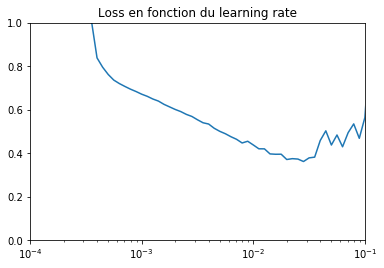

In [172]:
plt.title("Loss en fonction du learning rate")
lrs = 1e-9 * (10 ** (np.arange(200) / 20))
plt.semilogx(lrs, model.history.history["loss"])
plt.axis([1e-4, 1e-1, 0,1])

In [211]:
#Specifying the good learning rate
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, activation=activation, input_dim=dim,kernel_initializer='normal',kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01)), 
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(20, activation=activation), 
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation="linear")
])
optimizer = tf.keras.optimizers.SGD(lr=1*1e-3, momentum=0.9)
model.compile(loss="mae", optimizer=optimizer)
model.fit(np.array(X_train), np.array(y_train), epochs=3000, verbose=0)

In [212]:
ypred_te=np.expm1(model.predict(np.array(X_test)).reshape(-1))
y_test=np.expm1(y_test)
ypred_tr=np.expm1(model.predict(np.array(X_train)).reshape(-1))
y_train=np.expm1(y_train)

In [213]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error
print("R2_score_train :",round(r2_score(y_train,ypred_tr),3),"\n","R2_score_test :",round(r2_score(y_test,ypred_te),3),"\n","MAE_score_train :",round(mean_absolute_error(y_train,ypred_tr),0),"\n","MAE_score_test :",round(mean_absolute_error(y_test,ypred_te),0))

R2_score_train : 0.939 
 R2_score_test : 0.894 
 MAE_score_train : 12408.0 
 MAE_score_test : 14778.0


On a entraîné un réseau de neurones avec 3 couches cachées respectivement 50, 20 et 10 neurones avec une activation sigmoid. Le dernier neurone aggrege linéairement les résultats de la dernière couche cachée. Comme nous l'avions anticipé, ce réseau de neurones permet d'atteindre des performances légèrement meilleures: avec notamment une MAE sur le test de +/- 13.8 K€

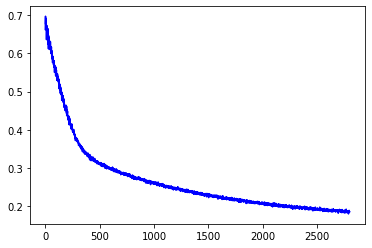

In [214]:
loss = model.history.history['loss'][200:]
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()